# Forward Neural network

The forward model is a resnet model.


## Import modules

In [16]:
import os
import math
import numpy as np
import pandas as pd
import pickle
import h5py
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

## Set dynamic GPU memory growth

In [13]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


## Load preprocessed data

In [3]:
hdf5_file_name = "datasets/core_shell_particles_preprocessed_122500.h5"

f = h5py.File(hdf5_file_name, "r")
X_train = np.array(f["X_train"])
y_train = np.array(f["y_train"])
X_test = np.array(f["X_test"])
y_test = np.array(f["y_test"])
f.close()

In [4]:
X_train[0].shape

(16,)

### Custom Resnet model

#### Resblock

In [5]:
# decorator to register the custom resblock to allow serialziation and re-loading
@keras.utils.register_keras_serializable()  # for keras3
class ResBlock1D(keras.Model):
    def __init__(self, filters, kernel_size=3, convblock=False, **kwargs):
        super(ResBlock1D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        # setup all necessary layers
        self.conv1 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn1 = keras.layers.BatchNormalization()

        self.conv2 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn2 = keras.layers.BatchNormalization()

        # self.relu = keras.layers.LeakyReLU()
        self.relu = keras.layers.LeakyReLU(negative_slope=0.01)

        self.convblock = convblock
        if self.convblock:
            self.conv_shortcut = keras.layers.Conv1D(filters, 1)

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # add shortcut. optionally pass it through a Conv
        if self.convblock:
            x_sc = self.conv_shortcut(input_tensor)
        else:
            x_sc = input_tensor
        x += x_sc
        return self.relu(x)

    def get_config(self):
        base_config = super().get_config()
        return {
            "convblock": self.convblock,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            **base_config,
        }

#### Full resnet

In [6]:
N_rb = 4  # Nr of resblocks per size


def create_custom_resnet_model(input_shape):
    inputs = keras.layers.Input(shape=(input_shape,))

    x = inputs
    x = keras.layers.Dense(8192)(x)
    x = keras.layers.LeakyReLU(negative_slope=0.01)(x)
    x = keras.layers.Dense(4096)(x)
    x = keras.layers.LeakyReLU(negative_slope=0.01)(x)

    x = keras.layers.Dense(256 * 8)(x)
    x = keras.layers.LeakyReLU(negative_slope=0.01)(x)
    x = keras.layers.Reshape((8, 256))(x)

    for i in range(N_rb):
        x = ResBlock1D(filters=256)(x)
    x = keras.layers.UpSampling1D(size=2)(x)  # Upsample to length 16

    for i in range(N_rb):
        x = ResBlock1D(filters=256, convblock=(i == 0))(x)
    x = keras.layers.UpSampling1D(size=2)(x)  # Upsample to length 32

    for i in range(N_rb):
        x = ResBlock1D(filters=128, convblock=(i == 0))(x)
    x = keras.layers.UpSampling1D(size=2)(x)  # Upsample to length 64

    for i in range(N_rb):
        x = ResBlock1D(filters=128, convblock=(i == 0))(x)

    # Two output channels (forward and backward scattering)
    out_scat = keras.layers.Conv1D(2, kernel_size=1)(x)
    model = keras.Model(inputs=inputs, outputs=out_scat)

    return model

In [7]:
model_for_summary = create_custom_resnet_model(X_train.shape[1])
model_for_summary.summary()

I0000 00:00:1741711703.684185  209349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741711703.686910  209349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741711703.688312  209349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741711703.783847  209349 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8192)           │       139,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d (ResBlock1D)        │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_1 (ResBlock1D)      │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_2 (ResBlock1D)      │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_3 (ResBlock1D)      │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_4 (ResBlock1D)      │ (None, 16, 256)        │       461,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_5 (ResBlock1D)      │ (None, 16, 256)        │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_6 (ResBlock1D)      │ (None, 16, 256)        │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_7 (ResBlock1D)      │ (None, 16, 256)        │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_8 (ResBlock1D)      │ (None, 32, 128)        │       181,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_9 (ResBlock1D)      │ (None, 32, 128)        │        99,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_10 (ResBlock1D)     │ (None, 32, 128)        │        99,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_11 (ResBlock1D)     │ (None, 32, 128)        │        99,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_12 (ResBlock1D)     │ (None, 64, 128)        │       116,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_13 (ResBlock1D)     │ (None, 64, 128)        │        99,58

 Total params: 46,215,938 (176.30 MB)

 Trainable params: 46,203,650 (176.25 MB)

 Non-trainable params: 12,288 (48.00 KB)

## Train the model - Hybrid Method (Increase learning rate and Decay learning)

### instantiate the model

In [8]:
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)
model = create_custom_resnet_model(X_train_new.shape[1])

### Parameters

In [9]:
initial_batch_size = 2
max_batch_size = 256
initial_lr = 0.0001
decay_factor = 0.5
step_size = 15
epochs = 300
validation_split = 0.1
patience = 20

# Set initial batch size and learning rate
current_batch_size = initial_batch_size
current_lr = initial_lr

# Assume `model` is already defined and compiled, for example:
# model = tf.keras.models.Sequential([...])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=current_lr), loss='mse')

history = {"loss": [], "val_loss": []}
best_val_loss = np.inf
patience_counter = 0

#  Compile Model
optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss="mse")

### Train


Epoch 1 - Training with Batch Size: 2, Learning Rate: 0.000100


I0000 00:00:1741711726.907525  209872 service.cc:146] XLA service 0x721f88002fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741711726.907540  209872 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-11 17:48:47.102885: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-11 17:48:47.962517: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   15/54000 ━━━━━━━━━━━━━━━━━━━━ 10:55 12ms/step - loss: 7.6372 

I0000 00:00:1741711735.052827  209872 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54000/54000 ━━━━━━━━━━━━━━━━━━━━ 643s 12ms/step - loss: 0.0948 - val_loss: 0.0141
Epoch 1: Loss = 0.038346, Validation Loss = 0.014138

Epoch 2 - Training with Batch Size: 2, Learning Rate: 0.000100
54000/54000 ━━━━━━━━━━━━━━━━━━━━ 628s 12ms/step - loss: 0.0117 - val_loss: 0.0093
Epoch 2: Loss = 0.010201, Validation Loss = 0.009282

Epoch 3 - Training with Batch Size: 2, Learning Rate: 0.000100
54000/54000 ━━━━━━━━━━━━━━━━━━━━ 630s 12ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 3: Loss = 0.006723, Validation Loss = 0.007848

Epoch 4 - Training with Batch Size: 2, Learning Rate: 0.000100
54000/54000 ━━━━━━━━━━━━━━━━━━━━ 627s 12ms/step - loss: 0.0054 - val_loss: 0.0074
Epoch 4: Loss = 0.005153, Validation Loss = 0.007373

Epoch 5 - Training with Batch Size: 2, Learning Rate: 0.000100
54000/54000 ━━━━━━━━━━━━━━━━━━━━ 627s 12ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 5: Loss = 0.004237, Validation Loss = 0.004483

Epoch 6 - Training with Batch Size: 2, Learning Rate: 0.000100
54000

2025-03-11 23:07:15.648592: W external/local_tsl/tsl/framework/bfc_allocator.cc:363] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 3.4873e-05 - val_loss: 6.4346e-05
Epoch 106: Loss = 0.000035, Validation Loss = 0.000064

Epoch 107 - Training with Batch Size: 256, Learning Rate: 0.000001
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 3.4165e-05 - val_loss: 6.4332e-05
Epoch 107: Loss = 0.000035, Validation Loss = 0.000064

Epoch 108 - Training with Batch Size: 256, Learning Rate: 0.000001
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3.4683e-05 - val_loss: 6.4278e-05
Epoch 108: Loss = 0.000035, Validation Loss = 0.000064

Epoch 109 - Training with Batch Size: 256, Learning Rate: 0.000001
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3.4798e-05 - val_loss: 6.4242e-05
Epoch 109: Loss = 0.000035, Validation Loss = 0.000064

Epoch 110 - Training with Batch Size: 256, Learning Rate: 0.000001
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3.4798e-05 - val_loss: 6.4295e-05
Epoch 110: Loss = 0.000035, Validation Loss = 0.000064
Early stopping patience: 1/20

E

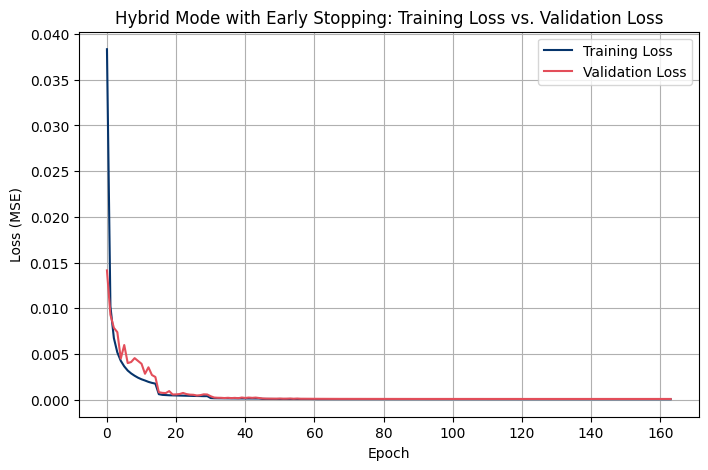

In [10]:
for epoch in range(epochs):
    print(
        f"\nEpoch {epoch+1} - Training with Batch Size: {current_batch_size}, Learning Rate: {current_lr:.6f}"
    )

    # Update the optimizer's learning rate
    model.optimizer.learning_rate.assign(float(current_lr))

    # Train for one epoch using model.fit
    hist = model.fit(
        X_train_new,
        y_train_new,
        batch_size=current_batch_size,
        epochs=1,
        verbose=1,
        validation_data=(X_val, y_val),
    )

    train_loss = hist.history["loss"][0]
    val_loss = hist.history["val_loss"][0]
    print(f"Epoch {epoch+1}: Loss = {train_loss:.6f}, Validation Loss = {val_loss:.6f}")

    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    # Early stopping check: Reset counter if validation loss improves, else increment
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

    # Update batch size and learning rate every `step_size` epochs
    if (epoch + 1) % step_size == 0:
        current_batch_size = min(current_batch_size * 2, max_batch_size)
        current_lr *= decay_factor
        print(
            f"Updated Batch Size: {current_batch_size}, Learning Rate: {current_lr:.6f}"
        )

# Plot the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history["loss"], color="#06346B", label="Training Loss")
plt.plot(history["val_loss"], color="#E34E5A", label="Validation Loss")
plt.title("Hybrid Mode with Early Stopping: Training Loss vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

### Save

In [11]:
# - save the model
model_filename = "models/resnet_Mie_predictor.keras"
model.save(model_filename)

# - save the training history
history_save_path = os.path.splitext(model_filename)[0] + "_hist.pkl"
with open(history_save_path, "wb") as f:
    pickle.dump(history, f)

### plot training convergence

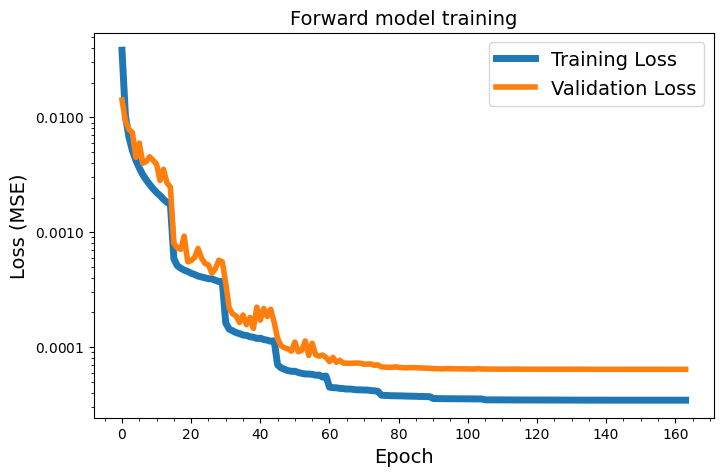

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(history["loss"], linestyle='-', linewidth=5, color='tab:blue', label='Training Loss')
plt.plot(history["val_loss"], linestyle='-', linewidth=4, color='tab:orange', label='Validation Loss')

# Title and labels with a slightly larger font size
plt.title("Forward model training", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss (MSE)", fontsize=14)

plt.legend(fontsize=14, loc='upper right', frameon=True)
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.minorticks_on()  # Grid and minor ticks

plt.show()